<a href="https://colab.research.google.com/github/SeongwonTak/Data_projects/blob/main/LOL_WinLose_Predict/LOLgameAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LOL game Analysis
Kaggle에서 유명 게임인 LOL과 관련된 데이터를 발견하였다.
여러가지를 실험해보기 좋아, LOL에 대해 아는 바가 없지만,
분석에 사용해보기로 하였다.

https://www.kaggle.com/gyejr95/league-of-legends-challenger-ranked-games2020

의 데이터를 활용하였다.

## 목표 설정
1. 기본적인 데이터 탐색
2. 블루 유리설은 사실인가? 왜 그런 이야기가 나올까 추리하기
3. 데이터만 보고 누가 이겼는지 추측할 수 있을까?

3가지에 대해 확인해보는 것이 목표이다.

데이터는 천상계라고 불리는 챌린저들의 경기를 사용할 것이다.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn as sk

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lolgamedata/Challenger_Ranked_Games.csv')

In [3]:
df_original = df.copy()

In [4]:
df

gameId  gameDuraton  ...  redTotalHeal  redObjectDamageDealt
0      4247263043         1323  ...         38711                 60463
1      4247155821         1317  ...         24829                 14105
2      4243963257          932  ...         12589                 45201
3      4241678498         2098  ...         65312                 88202
4      4241538868         2344  ...         86431                 64141
...           ...          ...  ...           ...                   ...
26899  4143231833         1468  ...         48596                 42733
26900  4157911901          970  ...         15817                 50217
26901  3764171638         1480  ...         25448                 27675
26902  4110201724         1837  ...         25003                 45455
26903  4100240254          948  ...          7138                  6808

[26904 rows x 50 columns]

## 기본적 데이터 탐색
LOL에 대해 잘 아는 바는 없지만, 간단한 목표는 확인해보았다.

- 미니언들이 블루팀, 레드팀 모두에서 동등하게 나오는 환경에서
- 5명의 각 팀의 영웅이 상대팀을 직접 때려잡던, 미니언도 잡아서 간접적으로 밀던 해서 한 팀의 넥서스(본진)을 부수면 이기는 게임
- '정글'의 존재로 '정글러'가 전투에 개입을 하던가 특수한 몬스터를 잡아 팀에 유리한 버프를 제공할 수 있다.


### 데이터 선별
필요한 데이터만 추출하여 데이터필드를 재구성하려고 한다.
- gameDuraton : X 변수로 추출 일단은.
- blueWins : 블루가 이기면 레드가 지니까, 블루만 Y변수로 추출.
- blueFirstBlood, blueFirstTower, blueFirstBaron, blueFirstDragon, blueFirstInhibitor : 블루가 먼저 따면 레드가 먼저가 아니니 블루만 X변수
- blueDragonKills,	blueBaronKills,	blueTowerKills,	blueInhibitorKills,	blueWardPlaced,	blueWardkills,	blueKills,	blueDeath,	blueAssist,	blueChampionDamageDealt,	blueTotalGold,	blueTotalMinionKills,	blueAvgLevel,	blueJungleMinionKills,	blueKillingSpree,	blueTotalHeal,	blueObjectDamageDealt	: 레드와의 비교를 위해 레드쪽에도 변수를 추출해야 한다. X 변수로 추출한다.

In [5]:
df_X = df[['gameDuraton', 'blueFirstBlood', 'blueFirstTower', 
           'blueFirstBaron', 'blueFirstDragon', 'blueFirstInhibitor',
           'blueDragonKills',	'blueBaronKills',	'blueTowerKills',	
           'blueInhibitorKills',	'blueWardPlaced',	'blueWardkills',	
           'blueKills',	'blueDeath',	'blueAssist',	'blueChampionDamageDealt',	
           'blueTotalGold',	'blueTotalMinionKills',	'blueAvgLevel',	
           'blueJungleMinionKills',	'blueKillingSpree',	'blueTotalHeal',	
           'blueObjectDamageDealt',
           'redDragonKills',	'redBaronKills',	'redTowerKills',	
           'redInhibitorKills',	'redWardPlaced',	'redWardkills',	
           'redKills',	'redDeath',	'redAssist',	'redChampionDamageDealt',	
           'redTotalGold',	'redTotalMinionKills',	'redAvgLevel',	
           'redJungleMinionKills',	'redKillingSpree',	'redTotalHeal',	
           'redObjectDamageDealt']]

In [6]:
df_y = df[['blueWins']]

In [7]:
df_X.head()

gameDuraton  blueFirstBlood  ...  redTotalHeal  redObjectDamageDealt
0         1323               1  ...         38711                 60463
1         1317               0  ...         24829                 14105
2          932               0  ...         12589                 45201
3         2098               0  ...         65312                 88202
4         2344               1  ...         86431                 64141

[5 rows x 40 columns]

먼저 확인하고 싶은 사항은, 이 중 연관성이 매우 짙어서 굳이 고려하지도 않아도 되는 변수는 제외하려고 한다. 블루팀의 수치 변수에 대해서 먼저 확인해보자.

In [8]:
df_blue_numeric= df[['blueDragonKills',	'blueBaronKills',	'blueTowerKills',	
           'blueInhibitorKills',	'blueWardPlaced',	'blueWardkills',	
           'blueKills',	'blueDeath',	'blueAssist',	'blueChampionDamageDealt',	
           'blueTotalGold',	'blueTotalMinionKills',	'blueAvgLevel',	
           'blueJungleMinionKills',	'blueKillingSpree',	'blueTotalHeal',	
           'blueObjectDamageDealt']]

In [9]:
df_blue_numeric.corr()

blueDragonKills  ...  blueObjectDamageDealt
blueDragonKills                 1.000000  ...               0.786844
blueBaronKills                  0.444917  ...               0.708695
blueTowerKills                  0.616723  ...               0.827560
blueInhibitorKills              0.397824  ...               0.575319
blueWardPlaced                  0.521019  ...               0.661067
blueWardkills                   0.498708  ...               0.631655
blueKills                       0.335246  ...               0.433566
blueDeath                      -0.168296  ...              -0.107811
blueAssist                      0.204242  ...               0.288407
blueChampionDamageDealt         0.335955  ...               0.472199
blueTotalGold                   0.464688  ...               0.646047
blueTotalMinionKills            0.532084  ...               0.682345
blueAvgLevel                    0.397269  ...               0.559169
blueJungleMinionKills           0.648487  ...               0.789468
blueKillingSpree                0.284555  ...               0.375338
blueTotalHeal                   0.451424  ...               0.575053
blueObjectDamageDealt           0.786844  ...               1.000000

[17 rows x 17 columns]

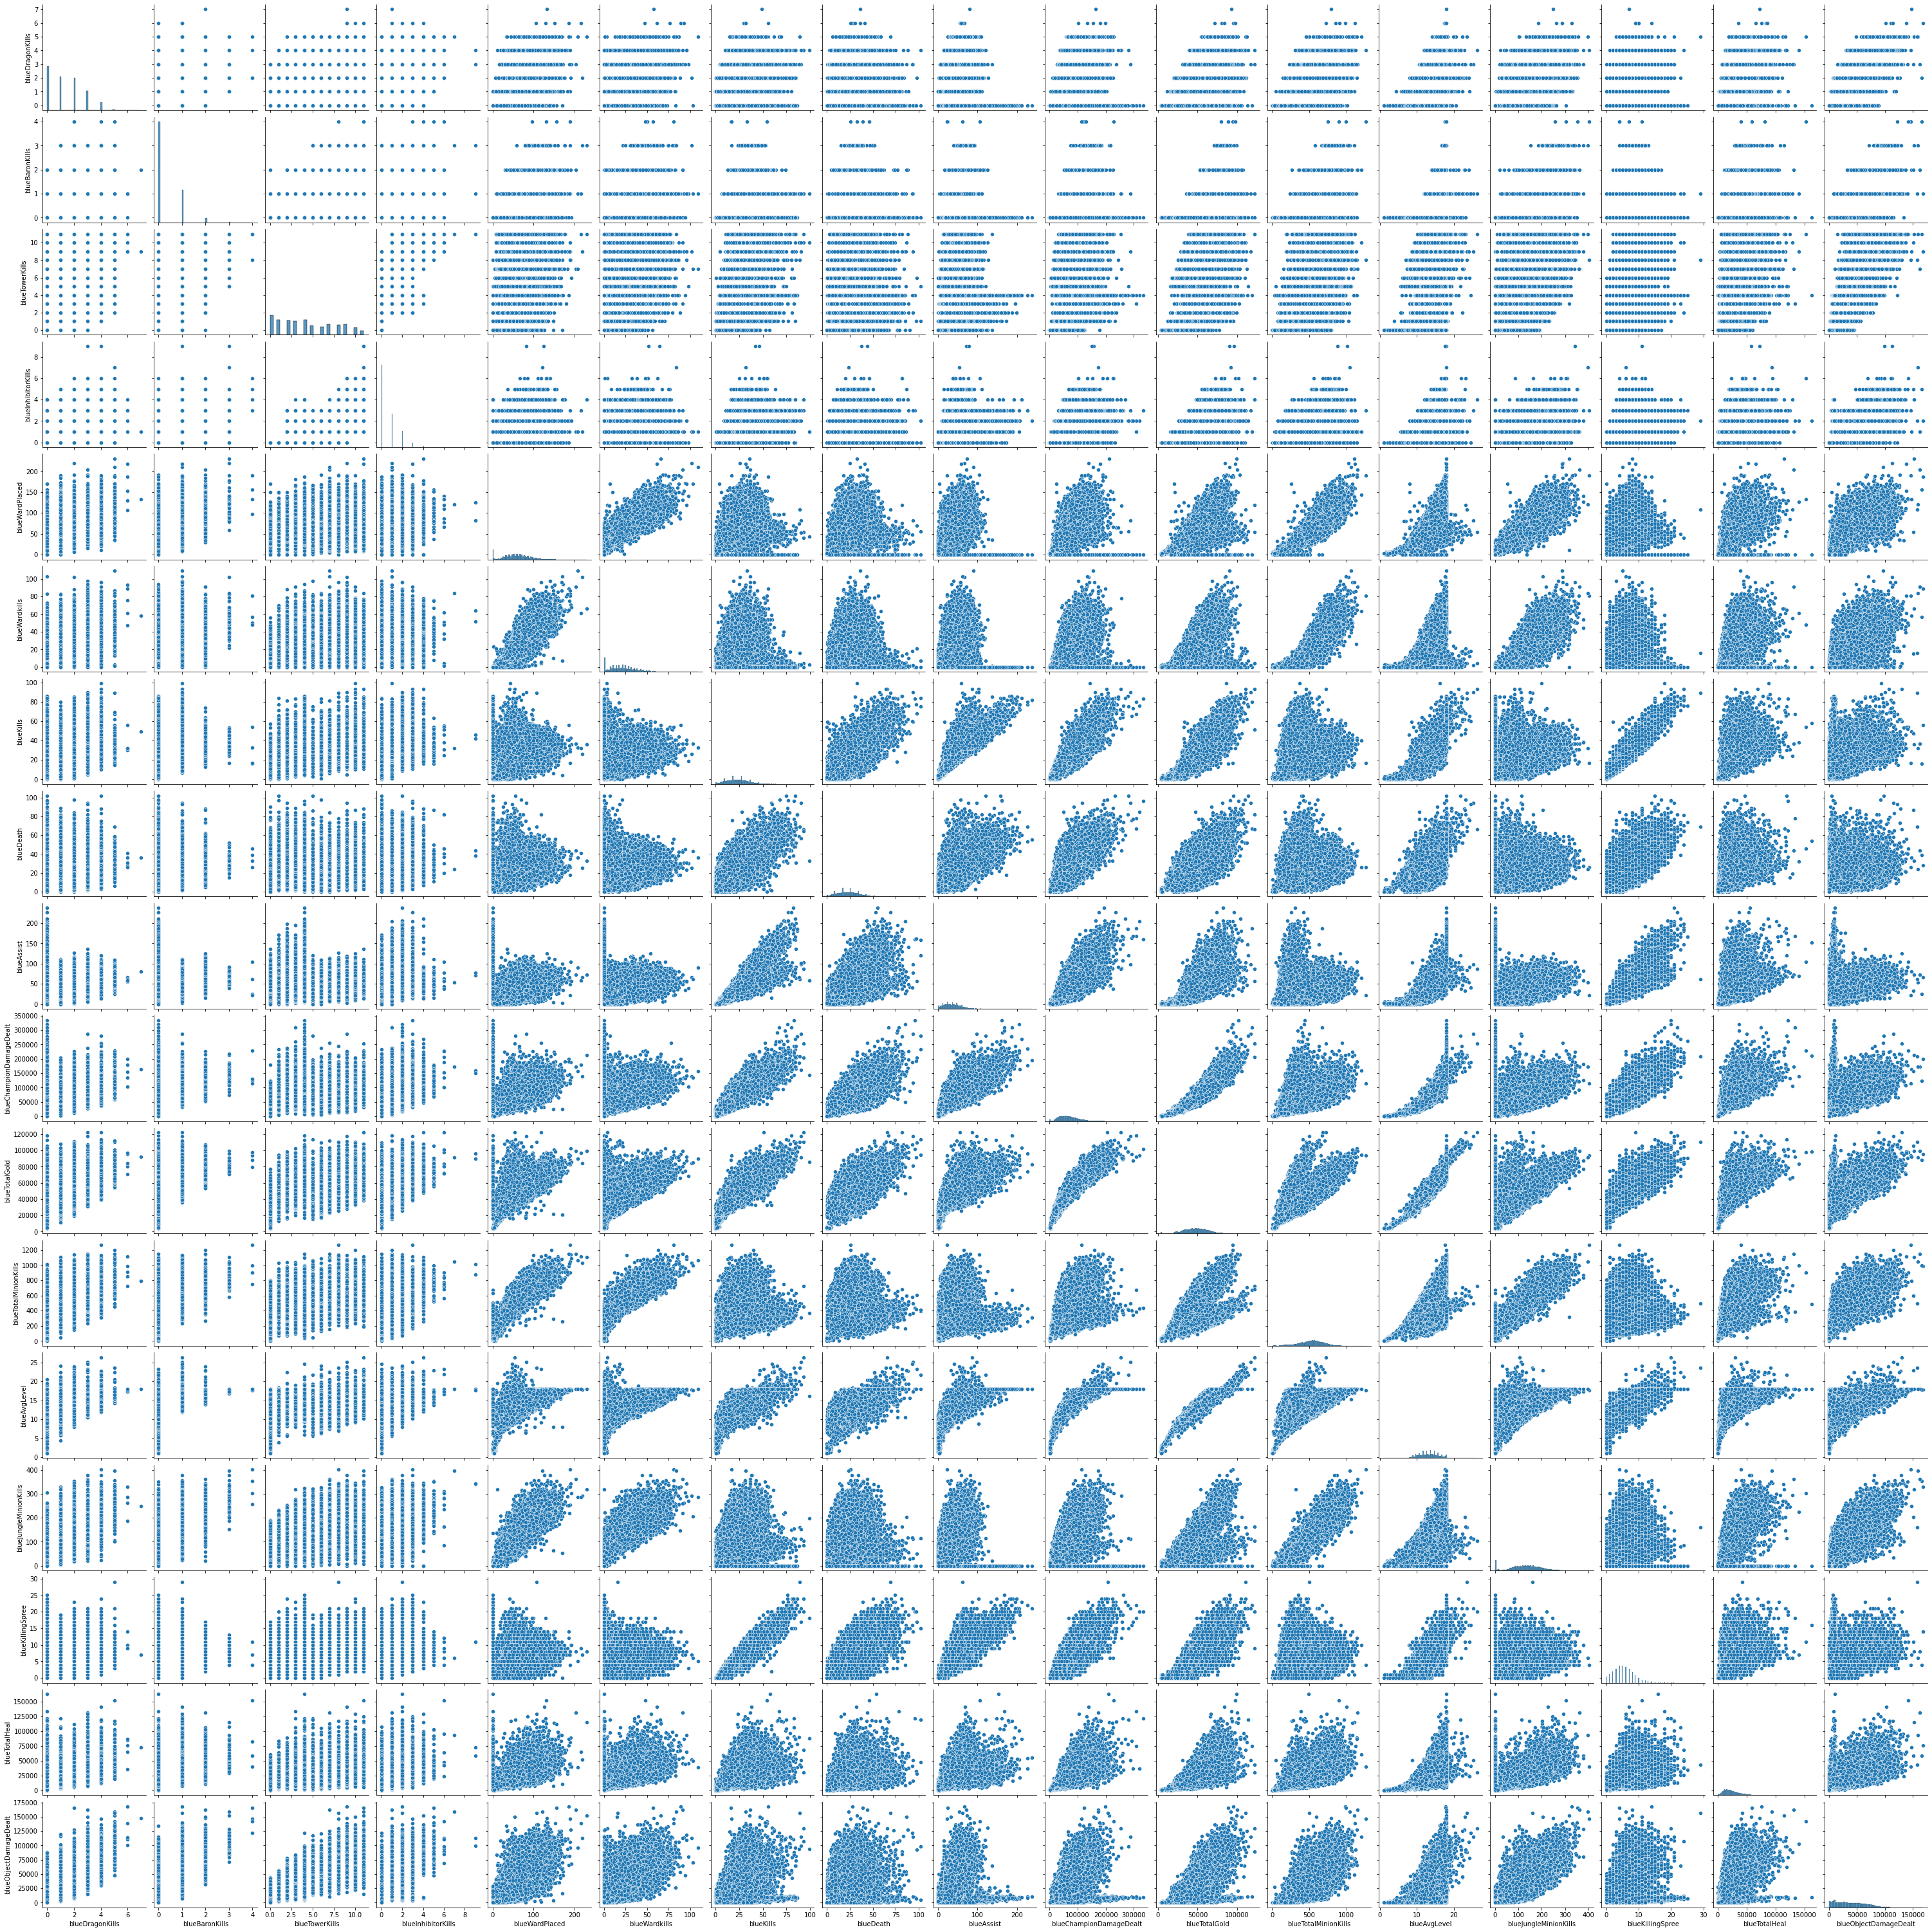

In [10]:
sns.pairplot(df_blue_numeric)

변수에 대해 상관관계를 확인하고 몇 가지 검토를 해본 결과 우선적으로 변수를 좀 줄일 수 있을거 같다.
- 먼저, 우리 팀의 킬 수 = 상대팀의 킬 수 이다. 따라서 레드팀의 킬, 데스 순은 고려하지 않아도 좋을 것이다.
- 또한 어시스트가 킬에 직접적으로 영향을 주기에 어시스트는 고려하지 않아도 좋아보인다. (킬에 딸려나오는 카운트기에)
- 골드는 레벨이 높을수록, 더 많이 미니언을죽일수록. 등등 다른 변수에 굉장히 종속적이므로 누적 골드 또한 없어도 문제없을 것이다.
- 비슷한 원리로 레벨 또한 킬수, 킬 미니언수 등등 전체적인 사냥을 반영한 팀 수치이므로 레벨 또한 없어도 문제없을 것이다.

이에따라 변수를 몇개 제거하여 다시 df_X를 만들면 다음과 같다.

In [11]:
df_X2 = df[['gameDuraton', 'blueFirstBlood', 'blueFirstTower', 
           'blueFirstBaron', 'blueFirstDragon', 'blueFirstInhibitor',
           'blueDragonKills',	'blueBaronKills',	'blueTowerKills',	
           'blueInhibitorKills',	'blueWardPlaced',	'blueWardkills',	
           'blueKills',	'blueDeath', 'blueChampionDamageDealt',	
           'blueTotalMinionKills',
           'blueJungleMinionKills',	'blueKillingSpree',	'blueTotalHeal',	
           'blueObjectDamageDealt',
           'redDragonKills',	'redBaronKills',	'redTowerKills',	
           'redInhibitorKills',	'redWardPlaced',	'redWardkills',	
           'redChampionDamageDealt',	
           'redTotalMinionKills',	
           'redJungleMinionKills',	'redKillingSpree',	'redTotalHeal',	
           'redObjectDamageDealt']]

### 데이터 탐색 및 검토

새로운 df_X2를 바탕으로 블루팀의 승패를 예측하려고 한다. **하지만, 그 전에 몇가지 내용을 확인하고자 한다.**

- 블루 vs 레드 어디가 유리한가?
- 킬이 더 많으면 무조건 이기는가?
- 선빵필승일까? 다시말해 선과 관련된 4개의 변수는 승패와 얼마나 연관되어 있을까?

In [12]:
df['blueWins'].sum() / len(df['blueWins'])

0.5000743383883437

**천상계 유저**들 간에는 블루, 레드간 큰 승률차이는 없다.

In [13]:
df_X2['kill_cmprsn'] = [1 if df_X2['blueKills'][i] >= df_X2['blueDeath'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


gameDuraton  blueFirstBlood  ...  redObjectDamageDealt  kill_cmprsn
0             1323               1  ...                 60463            0
1             1317               0  ...                 14105            1
2              932               0  ...                 45201            0
3             2098               0  ...                 88202            0
4             2344               1  ...                 64141            0
...            ...             ...  ...                   ...          ...
26899         1468               1  ...                 42733            0
26900          970               1  ...                 50217            0
26901         1480               1  ...                 27675            0
26902         1837               1  ...                 45455            1
26903          948               1  ...                  6808            1

[26904 rows x 33 columns]

In [14]:
kill_win = pd.DataFrame(data = {'win': list(df['blueWins']),
                                'kill_cmprsn': list(df_X2['kill_cmprsn']) })

In [15]:
kill_win

win  kill_cmprsn
0        0            0
1        1            1
2        0            0
3        0            0
4        1            0
...    ...          ...
26899    0            0
26900    0            0
26901    0            0
26902    1            1
26903    1            1

[26904 rows x 2 columns]

In [16]:
kill_win.iloc[1,1]

1

In [17]:
count = 0
for i in range(26903):
  if kill_win.iloc[i,0] == kill_win.iloc[i,1]:
    count += 1
print(count / 26903 * 100)

94.2720142735011


data set에서 kill이 더 많은 쪽이 이긴다를 94.272% 정도로 예측한다.
따라서, 우리는 이거보다는 더 좋은 예측을 하는 것을 목표로 해야 할 것이다. 

이제 선과 관련된 5개의 변수에 대해 확인해보자.

In [18]:

first_list = ['blueFirstBlood', 'blueFirstTower', 
           'blueFirstBaron', 'blueFirstDragon', 'blueFirstInhibitor']
for i in range(5):
  count = 0
  for j in range(26903):
    if df.loc[j,'blueWins'] == df_X2.loc[j, first_list[i]]:
      count += 1
  print(count / 26903 * 100)

60.320410363156526
72.42314983459094
65.75103148347769
63.15280823699959
80.73077351968182


타워나 억제기를 먼저 깬 경우에는 승리할 확률이 70% 이상으로 높은 편이나,
나머지 경우는 높아야 65% 정도로 어느정도 뒤집을 확률이 충분히 존재함을 알 수 있다.

## 승부 예측기 Idea

여러 Idea가 있는데 먼저 다음 두가지를 시도해보자.
- blue vs red별로 변수 비교를 하여, 더 큰쪽에 1표를 주는 방식을 사용한다.
 그 후 다수결 투표를 붙여 더 많이 나온 쪽을 승리라고 해주자.
- Tree 모델을 사용해보자.
- Tree 모델에서 나온 주요 변수로 다시 다수결을 해보자.

### 다수결 방법

가장 단순한 방법 중 하나이다. 
여기서는, 우선적으로 선빵을 제외한 13개의 변수만 고려햐여보자.

In [19]:
df_X2['dargonkill_cmprsn'] = [1 if df_X2['blueDragonKills'][i] >= df_X2['redDragonKills'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['baronkill_cmprsn'] = [1 if df_X2['blueBaronKills'][i] >= df_X2['redBaronKills'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['towerkill_cmprsn'] = [1 if df_X2['blueTowerKills'][i] >= df_X2['redTowerKills'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['inhibitorkill_cmprsn'] = [1 if df_X2['blueInhibitorKills'][i] >= df_X2['redInhibitorKills'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['wardplaced_cmprsn'] = [1 if df_X2['blueWardPlaced'][i] >= df_X2['redWardPlaced'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['wardkill_cmprsn'] = [1 if df_X2['blueWardkills'][i] >= df_X2['redWardkills'][i] else 0 for i in range(len(df_X2['blueKills']))]

df_X2['champdeal_cmprsn'] = [1 if df_X2['blueChampionDamageDealt'][i] >= df_X2['redChampionDamageDealt'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['minionkill_cmprsn'] = [1 if df_X2['blueTotalMinionKills'][i] >= df_X2['redTotalMinionKills'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['jungminikill_cmprsn'] = [1 if df_X2['blueJungleMinionKills'][i] >= df_X2['redJungleMinionKills'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['spree_cmprsn'] = [1 if df_X2['blueKillingSpree'][i] >= df_X2['redKillingSpree'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['heal_cmprsn'] = [1 if df_X2['blueTotalHeal'][i] >= df_X2['redTotalHeal'][i] else 0 for i in range(len(df_X2['blueKills']))]
df_X2['objdeal_cmprsn'] = [1 if df_X2['blueObjectDamageDealt'][i] >= df_X2['redObjectDamageDealt'][i] else 0 for i in range(len(df_X2['blueKills']))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [20]:
count = 0
for i in range(26903):
  if int(df_X2.loc[i,'kill_cmprsn'])+\
  int(df_X2.loc[i,'dargonkill_cmprsn'])+\
  int(df_X2.loc[i,'baronkill_cmprsn'])+\
  int(df_X2.loc[i,'towerkill_cmprsn'])+\
  int(df_X2.loc[i,'inhibitorkill_cmprsn'])+\
  int(df_X2.loc[i,'wardplaced_cmprsn'])+\
  int(df_X2.loc[i,'wardkill_cmprsn'])+\
  int(df_X2.loc[i,'champdeal_cmprsn'])+\
  int(df_X2.loc[i,'minionkill_cmprsn'])+\
  int(df_X2.loc[i,'jungminikill_cmprsn'])+\
  int(df_X2.loc[i,'spree_cmprsn'])+\
  int(df_X2.loc[i,'heal_cmprsn'])+\
  int(df_X2.loc[i,'objdeal_cmprsn']) >= 7:
    if df.loc[i,'blueWins'] == 1:
      count += 1
  else:
    if df.loc[i, 'blueWins'] == 0:
      count += 1

print(count/26903 * 100)

94.85559231312493


0.6% 정도 향상시켰다.
이번에는 위에서 본 선중 타워와 억제기 변수를 추가하여 15개의 변수중 8개 이상으로 판정해보자.


In [21]:
count = 0
for i in range(26903):
  if int(df_X2.loc[i,'kill_cmprsn'])+\
  int(df_X2.loc[i,'dargonkill_cmprsn'])+\
  int(df_X2.loc[i,'baronkill_cmprsn'])+\
  int(df_X2.loc[i,'towerkill_cmprsn'])+\
  int(df_X2.loc[i,'inhibitorkill_cmprsn'])+\
  int(df_X2.loc[i,'wardplaced_cmprsn'])+\
  int(df_X2.loc[i,'wardkill_cmprsn'])+\
  int(df_X2.loc[i,'champdeal_cmprsn'])+\
  int(df_X2.loc[i,'minionkill_cmprsn'])+\
  int(df_X2.loc[i,'jungminikill_cmprsn'])+\
  int(df_X2.loc[i,'spree_cmprsn'])+\
  int(df_X2.loc[i,'heal_cmprsn'])+\
  int(df_X2.loc[i,'objdeal_cmprsn'])+\
  int(df_X2.loc[i,'blueFirstTower'])+\
  int(df_X2.loc[i,'blueFirstInhibitor']) >= 8:
    if df.loc[i,'blueWins'] == 1:
      count += 1
  else:
    if df.loc[i, 'blueWins'] == 0:
      count += 1

print(count/26903 * 100)

95.19384455265212


2개의 변수를 추가한 결과 95.1% 정도로 승률을 정확하게 예측하고 있다. 허나 이것은 Train Set에 대한 결과이므로 추후에 다른 랭크의 데이터 셋을 Test set으로 활용하여 최종 결과를 확인할 것이다.

그 전에, 상단의 15개의 변수를 별도로 묶어서 하나의 변수로 만들려고 한다.

In [22]:
df_game_factor = df_X2[['kill_cmprsn', 'dargonkill_cmprsn','baronkill_cmprsn',
                'towerkill_cmprsn', 'inhibitorkill_cmprsn', 
                'wardplaced_cmprsn', 'wardkill_cmprsn',
                'champdeal_cmprsn', 'minionkill_cmprsn',
                'jungminikill_cmprsn', 'spree_cmprsn',
                'heal_cmprsn', 'objdeal_cmprsn', 'blueFirstTower',
                'blueFirstInhibitor']]

### 결정트리
결정 트리를 사용하여  0 또는 1로 분류시키는 방법을 사용하여 보자.
위의 15가지 변수를 동일하게 사용할 것이다.

In [23]:
from sklearn.tree import DecisionTreeClassifier

X = df_game_factor
y = df_y
decision_tree = DecisionTreeClassifier(random_state = 0, 
                                      max_depth=4, 
                                      criterion='gini')
decision_tree = decision_tree.fit(X,y)


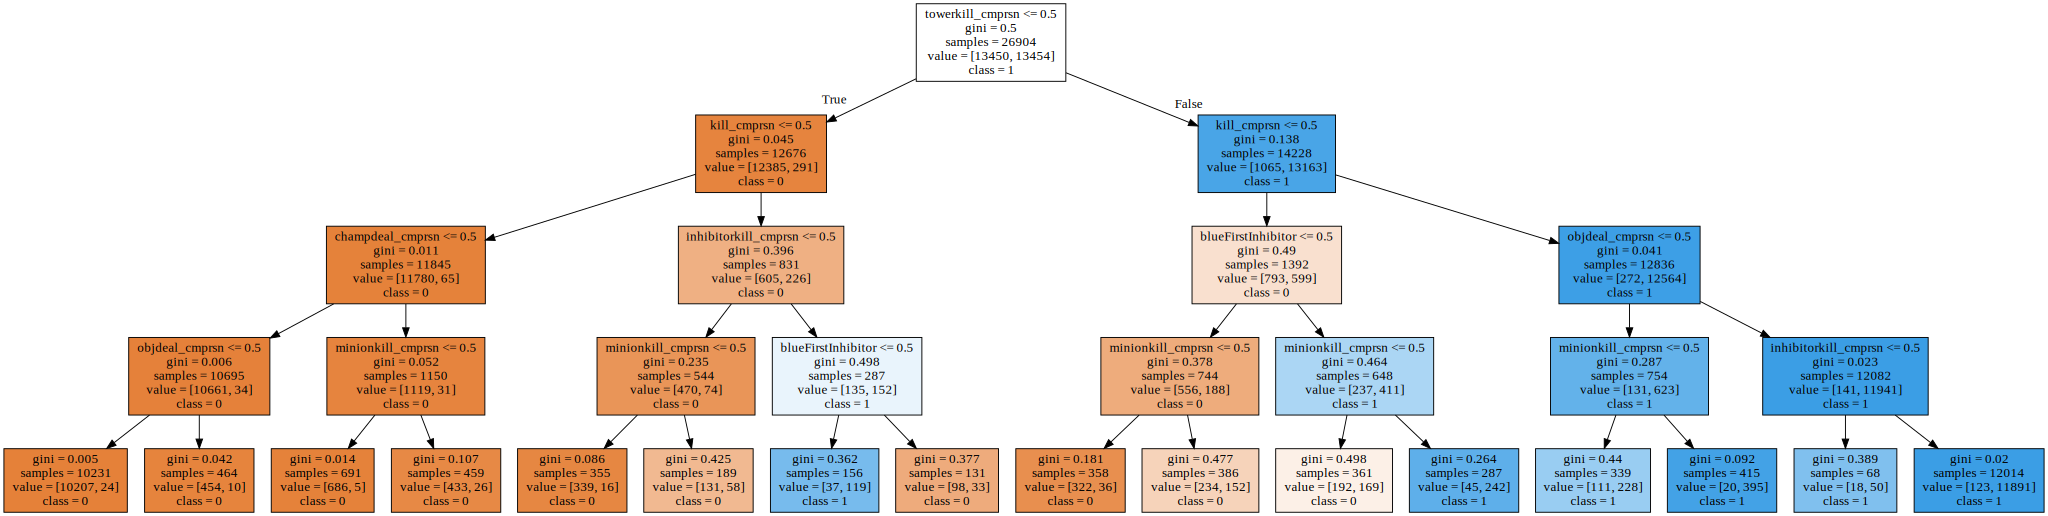

In [24]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names = df_game_factor.columns,
                                filled = True,
                                class_names=['0','1'])
graph = graphviz.Source(dot_data)
graph

In [25]:
from sklearn.metrics import accuracy_score
res_pred = decision_tree.predict(X)
score = accuracy_score(df_y, res_pred)
score

0.9671796015462385

모델의 사용 결과, train set에서는 96% 정도의 정확도를 보이고 있다.
여기서 눈에 띄는 점은 사용된 변수가 생각보다 많지 않다는 점이다.
- towerkill
- kill수
- champdeal
- blue first inhibitor
- inhibitor kill
- minnnion kill
- objdeal
단 7개의 변수만 트리에 사용됨을 알 수 있다.
그럼 다시 생각나는 방법이, 아예 이 7개의 변수만 다수결에 반영하면 어떨까
이런 생각이든다.
바로 해보자.

7개의 변수중 4개가 높으면 승리로 판단해주자.

In [26]:
count = 0
for i in range(26903):
  if int(df_X2.loc[i,'kill_cmprsn'])+\
  int(df_X2.loc[i,'towerkill_cmprsn'])+\
  int(df_X2.loc[i,'inhibitorkill_cmprsn'])+\
  int(df_X2.loc[i,'champdeal_cmprsn'])+\
  int(df_X2.loc[i,'minionkill_cmprsn'])+\
  int(df_X2.loc[i,'objdeal_cmprsn'])+\
  int(df_X2.loc[i,'blueFirstInhibitor']) >= 4:
    if df.loc[i,'blueWins'] == 1:
      count += 1
  else:
    if df.loc[i, 'blueWins'] == 0:
      count += 1

print(count/26903 * 100)

96.72898933204476


확실히 트리를 통해 주요 변수를 찾아서 판단한 결과 기존 다수결 대비 훈련 세트에서 더 좋은 결과를 얻어냈다!

### 로지스틱 회귀
혹시 모르니까, 로지스틱 회귀를 사용해보려고 한다.
우선 기본 15변수랑, 주요 7변수 기준으로 두가지를 비교해보자.

In [27]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(df_game_factor, df_y)
print(model.score(df_game_factor, df_y))

0.9722346119536128


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트에서 정확도가 97% 정도로 매우 우수함을 알 수 있다.
여기서도 중요 변수가 무엇인지 가를 수 있다. 계수를 확인해보자.

In [28]:
print(model.coef_)

[[ 2.42006089 -0.26343878  0.66899029  2.79773559  1.24343547  0.40462052
  -0.2233264   1.708659    2.12434654  0.03927473  0.57067247  1.41910792
   1.67354034 -0.58465905  1.10478368]]



계수의 (절대값) 크기를 비교해보면
- tower_kill이 우세하면
- kill수가 우세하면
- 미니언킬수가 우세하면
- 챔피언의 딜량이 우세하면
- 오브젝트에 넣은 딜량이 우세하면
- 힐량이 우수하면
- 억제기를 부순 양이 많으면
- 억제기를 먼저 부쉈으면
..

앞에서와 다르게 힐량이라는 조건이 여기에 추가된다.
또한 주목할 점은 음수의 값과 0에 가까운 값이 보인다는 점이다.
- 드래곤킬수, 첫타워 격파여부, 와드를 죽인 양 수는 오히려 승패판단에 음의 여부를 가진다. 드래곤이나 와드는 버프요소인데 의외의 결과이다.
- 정글러가 미니언을 더 많이 죽이고 말고는 크게 상관이 없다고 말하고 있다.

위의 말을 바탕으로 영향이 없거나 반대로 측정하는 변수를 제거하여 전체 다수결을 다시 시켜볼 수도 있을 것이다. 해보자.

In [29]:
count = 0
for i in range(26903):
  if int(df_X2.loc[i,'kill_cmprsn'])+\
  int(df_X2.loc[i,'baronkill_cmprsn'])+\
  int(df_X2.loc[i,'towerkill_cmprsn'])+\
  int(df_X2.loc[i,'inhibitorkill_cmprsn'])+\
  int(df_X2.loc[i,'wardplaced_cmprsn'])+\
  int(df_X2.loc[i,'champdeal_cmprsn'])+\
  int(df_X2.loc[i,'minionkill_cmprsn'])+\
  int(df_X2.loc[i,'spree_cmprsn'])+\
  int(df_X2.loc[i,'heal_cmprsn'])+\
  int(df_X2.loc[i,'objdeal_cmprsn'])+\
  int(df_X2.loc[i,'blueFirstInhibitor']) >= 6:
    if df.loc[i,'blueWins'] == 1:
      count += 1
  else:
    if df.loc[i, 'blueWins'] == 0:
      count += 1

print(count/26903 * 100)

96.50968293498866


96.5%로 기존 다수결 판독기보다는 좋은 성능을 가지고 있으나, Tree에서 판별한 주요 7변수 다수결 판독기보다는 결과가 좋지 않다.

## 2021.09.27 보강_train test split 활용을 통한 재검증

이전에 했던 내용을 검토해 본 결과, train test split을 하지 않고 모델을 학습하였음을 확인하였다. 그냥 전체를 학습하고 몇%를 맞았는지를 확인하였다는 것을 보았다. 이에 따라, 다시 보강을 하여 진행하고자 한다.


In [30]:
# X : df_game_factor
# y : df_y
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_game_factor, df_y, test_size = 0.2, random_state = 42)

이를 기준으로 결정트리랑 로지스틱 회귀를 재학습하려고 한다.

In [31]:
# 평가지표 만들기
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def get_acc(pred, test):
  acc = accuracy_score(pred, test)
  pre = precision_score(pred, test)
  rec = recall_score(pred, test)
  f1 = f1_score(pred, test)
  print('accuracy : %.3f' % acc)
  print('precision : %.3f' % pre)
  print('recall :  %.3f' % rec)
  print('f1 score : %.3f' % f1)

In [32]:
# 로지스틱 회귀
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
get_acc(pred, y_test)

accuracy : 0.976
precision : 0.981
recall :  0.973
f1 score : 0.977


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
# 결정트리 재학습
# 시각화 과정은 제외한다.
decision_tree = DecisionTreeClassifier(random_state = 0, 
                                      max_depth=4, 
                                      criterion='gini')
decision_tree = decision_tree.fit(X_train,y_train)
pred = decision_tree.predict(X_test)
get_acc(pred, y_test)


accuracy : 0.971
precision : 0.969
recall :  0.973
f1 score : 0.971


## 2021.09.27 보강_lightgbm 활용
데이터가 10,000건 이상기에 이에 최적화 되어있는 앙상블 기법인 lightgbm을 활용하여 어느 지표가 정말 가장 승패의 결정에 영향이 컸는지를 확인하여 추가 해석을 진행하고자 한다.

In [34]:
from lightgbm import LGBMClassifier, plot_importance

In [45]:
lgbm = LGBMClassifier(n_estimators = 100, max_depth = 4, application = 'binary')
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
get_acc(lgbm_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy : 0.980
precision : 0.982
recall :  0.978
f1 score : 0.980


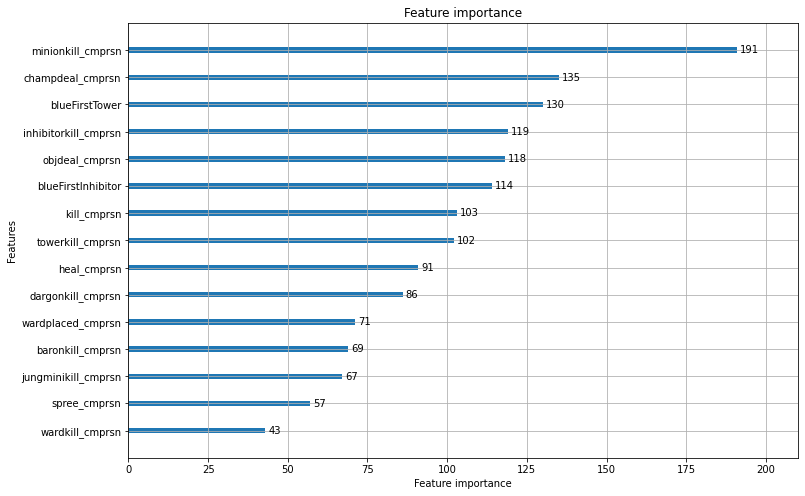

In [46]:
fig, ax = plt.subplots(figsize = (12, 8))
plot_importance(lgbm, ax = ax)

결정트리와는 다르게 lightgbm에서는 변수의 중요도가 조금 다르게 판별되었다.    
여기서는 미니언 킬 수가 조금 더 중요한 변수라고 말하고 있다.  
또한 타워의 개수 보다는 첫 타워를 조금 더 중요한 변수라고 판단하고 있다.  

## 결과의 검증 _ 다른 랭크에서는?(210927 일부 수정 : 지표 추가)
챌린저의 바로 아랫 단계 데이터를 통해 위에서 본 사실이 맞는기 검증해보려고 한다.

차이가 크다면 챌린저와 챌린저 아랫 등급과의 게임 양상 차이 또한 추론이 가능할 것이다.

그랜드 마스터 게임데이터를 사용해보자.

In [37]:
gm_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lolgamedata/GrandMaster_Ranked_Games.csv')

In [38]:
gm_df_y = gm_df[['blueWins']]

In [39]:
gm_df['kill_cmprsn'] = [1 if gm_df['blueKills'][i] >= gm_df['blueDeath'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['dargonkill_cmprsn'] = [1 if gm_df['blueDragonKills'][i] >= gm_df['redDragonKills'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['baronkill_cmprsn'] = [1 if gm_df['blueBaronKills'][i] >= gm_df['redBaronKills'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['towerkill_cmprsn'] = [1 if gm_df['blueTowerKills'][i] >= gm_df['redTowerKills'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['inhibitorkill_cmprsn'] = [1 if gm_df['blueInhibitorKills'][i] >= gm_df['redInhibitorKills'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['wardplaced_cmprsn'] = [1 if gm_df['blueWardPlaced'][i] >= gm_df['redWardPlaced'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['wardkill_cmprsn'] = [1 if gm_df['blueWardkills'][i] >= gm_df['redWardkills'][i] else 0 for i in range(len(gm_df['blueKills']))]

gm_df['champdeal_cmprsn'] = [1 if gm_df['blueChampionDamageDealt'][i] >= gm_df['redChampionDamageDealt'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['minionkill_cmprsn'] = [1 if gm_df['blueTotalMinionKills'][i] >= gm_df['redTotalMinionKills'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['jungminikill_cmprsn'] = [1 if gm_df['blueJungleMinionKills'][i] >= gm_df['redJungleMinionKills'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['spree_cmprsn'] = [1 if gm_df['blueKillingSpree'][i] >= gm_df['redKillingSpree'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['heal_cmprsn'] = [1 if gm_df['blueTotalHeal'][i] >= gm_df['redTotalHeal'][i] else 0 for i in range(len(gm_df['blueKills']))]
gm_df['objdeal_cmprsn'] = [1 if gm_df['blueObjectDamageDealt'][i] >= gm_df['redObjectDamageDealt'][i] else 0 for i in range(len(gm_df['blueKills']))]

In [40]:
gm_df

gameId  gameDuraton  ...  heal_cmprsn  objdeal_cmprsn
0      4241678498         2098  ...            0               0
1      4233222221         1686  ...            0               0
2      4233113995         1588  ...            1               1
3      4229230455         1126  ...            0               1
4      4228244819         1262  ...            0               1
...           ...          ...  ...          ...             ...
65891  3868504952         1928  ...            0               0
65892  4110201724         1837  ...            1               1
65893  4100240254          948  ...            1               1
65894  4216107910         2479  ...            1               1
65895  4195660684         1129  ...            1               1

[65896 rows x 63 columns]

In [41]:
gm_df_game_factor = gm_df[['kill_cmprsn', 'dargonkill_cmprsn','baronkill_cmprsn',
                'towerkill_cmprsn', 'inhibitorkill_cmprsn', 
                'wardplaced_cmprsn', 'wardkill_cmprsn',
                'champdeal_cmprsn', 'minionkill_cmprsn',
                'jungminikill_cmprsn', 'spree_cmprsn',
                'heal_cmprsn', 'objdeal_cmprsn', 'blueFirstTower',
                'blueFirstInhibitor']]

In [42]:
pred_gm = model.predict(gm_df_game_factor)
get_acc(pred_gm, gm_df_y)

accuracy : 0.970
precision : 0.975
recall :  0.966
f1 score : 0.970


바로 앞에서 본 로지스틱 회귀 모델을 동일하게 그랜드마스터 데이터에 사용해도 97% 정도로 우수한 예측률을 보여주고 있다.

주요 7변수 다수결에 대해서도 비슷한 예측률을 보여주는지 확인해보자.

In [43]:
count = 0
for i in range(65896):
  if int(gm_df.loc[i,'kill_cmprsn'])+\
  int(gm_df.loc[i,'towerkill_cmprsn'])+\
  int(gm_df.loc[i,'inhibitorkill_cmprsn'])+\
  int(gm_df.loc[i,'champdeal_cmprsn'])+\
  int(gm_df.loc[i,'minionkill_cmprsn'])+\
  int(gm_df.loc[i,'objdeal_cmprsn'])+\
  int(gm_df.loc[i,'blueFirstInhibitor']) >= 4:
    if gm_df.loc[i,'blueWins'] == 1:
      count += 1
  else:
    if gm_df.loc[i, 'blueWins'] == 0:
      count += 1

print(count/65896 * 100)

96.43680951802841


역시, 96% 정도로 유사한 결과를 보여주고 있다.
트리 모델도 비슷하게 나오는지 확인해보자.

In [44]:
res_pred = decision_tree.predict(gm_df_game_factor)
get_acc(gm_df_y, res_pred)

accuracy : 0.965
precision : 0.967
recall :  0.962
f1 score : 0.965


트리모델 또한 96% 정도의 예측 정확도로 챌린저 랭크에서 사용한 모델을 동일하게 사용해도 예측에 크게 무리가 없음을 알 수 있다.

## 2021.10.14 보강_오류 포인트에 대한 분석

어느 포인트에서 예측이 잘못되었는지 경향성이 있는지 확인해보고자 한다.  
여기서는 train set 에서의 lightgbm 모델을 기준으로 확인해보고자 한다. 

In [75]:
# blue0_error_idx : blue가 패했다고 예측했으나 실제로는 이긴 경기
# blue1_error_idx : blue가 승했다고 예측했으나 실제로는 패한 경기
# blue0_right_idx : blue가 패했다고 예측했으며 실제로도 패한 경기
# blue1_right_idx : blue가 승했다고 예측했으며 실제로도 이긴 경기
blue0_error_idx = []
blue1_error_idx = []
blue0_right_idx = []
blue1_right_idx = []
for i in range(len(y_test)):
  if lgbm_pred[i] == 0 and y_test.values[i] == 1:
    blue0_error_idx.append(y_test.index[i])
  elif lgbm_pred[i] == 1 and y_test.values[i] == 0:
    blue1_error_idx.append(y_test.index[i])
  elif lgbm_pred[i] == 0 and y_test.values[i] == 0:
    blue0_right_idx.append(y_test.index[i])
  elif lgbm_pred[i] == 1 and y_test.values[i] == 1:
    blue1_right_idx.append(y_test.index[i])

예측을 맞힌경기, 틀린 경기에들에 따라 유의미한 차이가 있나 확인해보려고 한다.

In [74]:
df_X.iloc[blue0_error_idx].describe()

gameDuraton  blueFirstBlood  ...  redTotalHeal  redObjectDamageDealt
count    49.000000       49.000000  ...     49.000000             49.000000
mean   1807.714286        0.591837  ...  40492.306122          54560.489796
std     452.859618        0.496587  ...  19622.352286          27620.606707
min     783.000000        0.000000  ...  14872.000000           5762.000000
25%    1539.000000        0.000000  ...  26393.000000          40595.000000
50%    1889.000000        1.000000  ...  36781.000000          57898.000000
75%    2074.000000        1.000000  ...  52351.000000          72982.000000
max    2912.000000        1.000000  ...  94603.000000          99480.000000

[8 rows x 40 columns]

In [76]:
df_X.iloc[blue0_right_idx].describe()

gameDuraton  blueFirstBlood  ...   redTotalHeal  redObjectDamageDealt
count  2602.000000     2602.000000  ...    2602.000000           2602.000000
mean   1429.845119        0.382398  ...   28449.657571          51634.637586
std     407.764072        0.486066  ...   15632.858090          23928.958579
min     191.000000        0.000000  ...     647.000000              0.000000
25%    1141.250000        0.000000  ...   17348.500000          34304.250000
50%    1412.500000        0.000000  ...   25567.000000          53199.500000
75%    1708.750000        1.000000  ...   36430.000000          68912.750000
max    2993.000000        1.000000  ...  120433.000000         149001.000000

[8 rows x 40 columns]

수치적인 부분을 평균으로 비교해본 결과 블루가 졌다고 예측했는데 이긴 경기는 상대팀인 레드팀의 전체적인 수치가 블루팀에 비해 평균치등이 높다는 것을 알 수 있다. 즉 레드와 블루의 승부가 굉장히 치열했다고 예측해 볼 수 있을 것이다.

In [77]:
df_X.iloc[blue1_error_idx].describe()

gameDuraton  blueFirstBlood  ...   redTotalHeal  redObjectDamageDealt
count    60.000000       60.000000  ...      60.000000             60.000000
mean   1729.066667        0.650000  ...   35874.300000          47636.683333
std     648.247621        0.480995  ...   21643.915958          29097.432793
min     191.000000        0.000000  ...     606.000000              0.000000
25%    1353.500000        0.000000  ...   24436.500000          23731.000000
50%    1942.500000        1.000000  ...   35096.500000          54822.500000
75%    2153.750000        1.000000  ...   44524.750000          66519.250000
max    2786.000000        1.000000  ...  104349.000000         117515.000000

[8 rows x 40 columns]

In [78]:
df_X.iloc[blue1_right_idx].describe()

gameDuraton  blueFirstBlood  ...  redTotalHeal  redObjectDamageDealt
count  2670.000000     2670.000000  ...   2670.000000           2670.000000
mean   1437.662172        0.599251  ...  21698.221723          22274.552809
std     407.906438        0.490142  ...  13275.825542          18311.056857
min     191.000000        0.000000  ...      0.000000              0.000000
25%    1155.000000        0.000000  ...  12162.750000           8371.250000
50%    1423.000000        1.000000  ...  19007.500000          17694.500000
75%    1717.750000        1.000000  ...  28411.750000          32585.000000
max    3051.000000        1.000000  ...  91572.000000         152319.000000

[8 rows x 40 columns]

역시 블루가 이겼다고 예측했으나, 레드가 이긴 경기에서 또한 레드의 성장치나 지표가 훨씬 더 높음을 알 수 있다.

즉, 양쪽이 치열하게 붙은 경기일수록, 분류에 어려움이 있다는 것을 알 수 있다.
그렇다면, 다음을 고려할 수 있을 것 같다.
- SVM을 고려해볼 수 있을까?

## 2021.10.14 보강_SVM 시도

In [79]:
X_train

kill_cmprsn  dargonkill_cmprsn  ...  blueFirstTower  blueFirstInhibitor
10505            1                  1  ...               1                   1
25187            0                  0  ...               0                   0
16444            1                  1  ...               1                   0
2450             0                  0  ...               1                   0
5940             0                  0  ...               0                   0
...            ...                ...  ...             ...                 ...
21575            0                  1  ...               0                   0
5390             1                  1  ...               1                   1
860              0                  0  ...               0                   0
15795            0                  0  ...               0                   0
23654            0                  0  ...               0                   0

[21523 rows x 15 columns]

In [80]:
# SVM 사용 시도
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)
svm_pred = clf.predict(X_test)
get_acc(svm_pred, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy : 0.980
precision : 0.981
recall :  0.979
f1 score : 0.980


LightGBM과 거의 유사한 정도의 정확도를 얻어냈음을 알 수 있다.!

## 결론
하위 랭크에 대해서는 다른 양상을 띌 수 있지만, 승패 예측이 유의미한 최상위권 랭크에서의 게임 예측은 다음 7개의 변수를 통해 확인 가능할 것이다.

- 타워를 더 많이 부순 팀은?
- 미니언에게 데미지를 더 많이 입힌 팀은?
- 챔피언에게 데미지를 더 많이 입힌 팀은?
- 건물에 데미지를 더 많이 입힌 팀은?
- 억제기를 더 많이 부순 팀은?
- 먼저 억제기를 깬 팀은?
- 더 많이 킬을 낸 팀은?

이 7개의 질문 중 4개 이상의 질문의 대답에 해당되는 팀이 이길 가능성이 최상위 경기에서는 약 96% 정도의 정확도를 보이고 있다.

다시 말해, 프로 경기에서 이전의 경기 결과 데이터가 있다면, 다음 경기의 승패 예측에 상위 7개의 기존 데이터를 활용하여 승부의 예측이나 주요 관전 포인트를 잡는데 도움이 될 것이라고 본다.

(상위 모델을 활용해도 무리가 없으나, 트리나 로지스틱 회귀에서 말하는 주요 변수가 상위 7가지라는 것을 얻어낼 수 있다.)

## 2021.10.14 보강_추가 해석 및 개선 고려사항
- 데이터를 지금은 변수별로 blue/red 우세에 대해서판 판단 했는데, 우세의 정도를 기준으로 모델링을 하면 얼마나 좋아질지에 대해서도 고민해 볼 수 있을 것이다.
- 레드가 성장한 만큼 블루도 같이 성장했을 것임을 추론할 수 있고 레드의 성장 정도를 표현할 다른 방법을 찾아봐야 할 것이다.
- 그런데 정말 precision과 recall을 봐야할까? 대칭적인 상황인데?